In [1]:
import numpy as np
import open3d as o3d
import copy
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

references:

> https://stackoverflow.com/questions/47932955/how-to-check-if-a-3d-point-is-inside-a-cylinder
> https://math.stackexchange.com/questions/3518495/check-if-a-general-point-is-inside-a-given-cylinder

## Params

In [2]:
global MAX_CYLINDER_DIAMETER, TRIALS, FACTOR, REMAINING_VOXELS
MAX_CYLINDER_DIAMETER = 8
TRIALS = 20
FACTOR = 1.5
REMAINING_VOXELS = 30

> a cylinder is defined by 3 parameters and these parameters are what this algorithm tries to find

    1. Cylinder center location
    2. Cylinder axis
    3. Clinder radius

In [3]:
def points_in_cylinder(pt1, pt2, radius, points):
    """
    find the points in a cylinder
    :pt1: 1st bounding point of the cylinder
    :pt2: 2nd bounding point of the cylinder
    :radius: radius of the cylinder
    :points: NumPy array of 3D points
    :return: NumPy boolean array of points inside of cylinder
    """
    vec = pt2 - pt1
    const = radius * np.linalg.norm(vec)
    cond1 = np.dot(points - pt1, vec) >= 0
    cond2 = np.dot(points - pt2, vec) <= 0
    cond3 = np.linalg.norm(np.cross(points - pt1, vec), axis=1) <= const
    
    cond4 = np.logical_and(cond1, cond2)
    cond5 = np.logical_and(cond3, cond4)
    
    return cond5

In [4]:
def find_radius(voxels, cylinder_axis):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :cylinder_axis: axis of the cylinder {0, 1, 2}
    :return: selected radius
    """
    # list of possible diameters [2, 10]
    diameters = list(range(MAX_CYLINDER_DIAMETER, 1, -1))

    # 2d plane perpendicular to the cylinder axis
    plane = list(range(3))
    plane.remove(cylinder_axis)    

    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)

    # perpendicular plane dimensions 
    fir_dim = maxx[plane[0]] - minn[plane[0]]
    sec_dim = maxx[plane[1]] - minn[plane[1]]

    # perpendicular plane smaller dimension
    min_dim = np.min([fir_dim, sec_dim])

    # heuristic: there should be more than 10 voxels after making the hole
    for d in diameters:
        diff = min_dim - d
        if diff > REMAINING_VOXELS:
            return int(d/2)

    return None

In [5]:
def find_axis_and_radius_exhaustive(voxels):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :return: pair: selected axis and radius
    """
    # try out the 3 possible axes
    axes = range(3)
    result = []
    for axis in axes:
        radius = find_radius(voxels, axis)
#         print(axis, radius)
        result.append(radius)
    
    # replace None with -1 to compute max
    result = [x or -1 for x in result]
    axis, radius = np.argmax(result), np.max(result)
    
    # return None if no appropriate radius and axis were found
    if radius == -1: 
        axis, radius = None, None
    
    return axis, radius

In [6]:
def find_cylinder_center(voxels, trials, plane, radius):
    """
    find an appropriate radius for the cylinder
    :voxels: voxel grid indices
    :trials: number of attempts for finding a suitable cylinder center
    :plane: 2d perpendicular plane of the cylinder
    :radius: cylinder radius
    :return: selected cylinder center voxel
    """
    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)
    
    axis = list(range(3))
    axis.remove(plane[0]) 
    axis.remove(plane[1])
    axis = axis[0]
    
    centers = []
    
    for trial in range(trials):
        # find a random voxel
        random_voxel_index = np.random.choice(voxels.shape[0], 1)[0]
        center_3d = voxels[random_voxel_index]
        
        # skip if cylinder center is too close to object boundaries.s
        cond1 = (center_3d[plane[0]] >= minn[plane[0]] + radius*2) and (center_3d[plane[0]] <= maxx[plane[0]] - radius*2)
        cond2 = (center_3d[plane[1]] >= minn[plane[1]] + radius*2) and (center_3d[plane[1]] <= maxx[plane[1]] - radius*2)
        if not (cond1 and cond2) :
            continue
            
        # set cylinder boundary points to the center
        pt1 = copy.deepcopy(center_3d)
        pt2 = copy.deepcopy(center_3d)

        # change 1 component based on the selected axis
        idx = axis
        pt1[idx] =  minn[idx]
        pt2[idx] =  maxx[idx]

        # identify voxels to be removed
        idx = points_in_cylinder(pt1, pt2, radius+2, voxels)
        selected_voxels = voxels[idx]
        selected_voxels = np.unique(selected_voxels[:, [plane[0], plane[1]]], axis = 0)
        
        # append possible centers
        centers.append((center_3d, selected_voxels.shape[0]))
    
    # pick the center with the most voxels
    centers.sort(key=lambda x: x[1])  
    center_3d = centers[-1][0]
    
    # hole has to be full
    min_voxels_num = np.ceil(np.pi * (radius)**2 * FACTOR) 
    if selected_voxels.shape[0] >= min_voxels_num:
        return center_3d
        
    return np.array([])        

In [7]:
# get the voxel grid indices out of the occupancy grid
model = np.load("models/top_20_models_voxelized/12.npz")['model']
voxels = np.argwhere(model == 1)

In [8]:
# fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
# ax = fig.gca(projection='3d')
# ax.voxels(model)
# plt.show()

In [9]:
# find appropriate axis and radius of the cylinder
axis, radius = find_axis_and_radius_exhaustive(voxels)
print("selected:", axis, radius)

if axis != None:
    plane = list(range(3))
    plane.remove(axis)
    center = find_cylinder_center(voxels, TRIALS, plane, radius)
    print("selected:", center)


0 None
1 None
2 4
selected: 2 4
selected: [50 28 30]


In [10]:
if axis != None and radius != None and center.size !=0:
    # maximum and minimum grid index 
    maxx = np.max(voxels, axis=0)
    minn = np.min(voxels, axis=0)
    
    # set cylinder boundary points to the center
    pt1 = copy.deepcopy(center)
    pt2 = copy.deepcopy(center)

    # change 1 component based on the selected axis
    idx = axis
    pt1[idx] =  minn[idx]
    pt2[idx] =  maxx[idx]

    # identify voxels to be removed
    idx = points_in_cylinder(pt1, pt2, radius, voxels)
    to_be_removed = voxels[idx]

    # remove selected voxels from the occupancy grid
    for v in to_be_removed:
        model[v[0], v[1], v[2]] = 0
else:
    print("hole creation not possible")

[50 28 30]


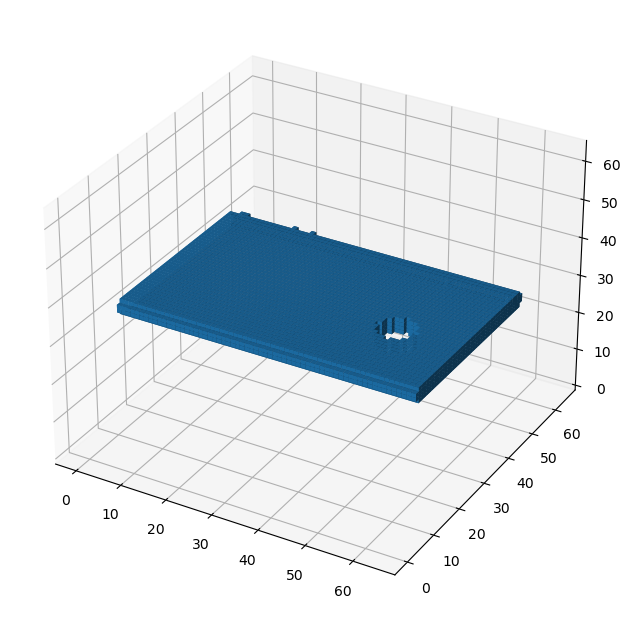

In [11]:
fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.voxels(model)
plt.show()